In [8]:
import pandas as pd
submission_data_1 = pd.read_csv('submission.csv')
submission_data_2 = pd.read_csv('submission_2.csv')

In [6]:
submission_data_1.head()


,id,class
0,0,O
1,1,Утечка нефти
2,2,O
3,3,O
4,4,O


In [9]:
submission_data_2.head()


,id,class
0,0,O
1,1,Утечка нефти
2,2,O
3,3,O
4,4,O


# Импорт библиотек

In [21]:
import pandas as pd
import numpy as np
import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters
from tensorflow.keras.utils import to_categorical

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments

import torch
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from transformers import AdamW

from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import TFRobertaModel
from transformers import RobertaTokenizerFast
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification

from transformers import DebertaTokenizer
from transformers import DebertaForSequenceClassification

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow.python.keras.engine

Using TensorFlow backend


C:\Users\NeKonn\AppData\Local\Temp\ipykernel_11224\3288496659.py:37: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import os

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
import string

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import RussianStemmer
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from torch.utils.data import Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
train_data = pd.read_csv('df_train.csv')
test_data = pd.read_csv('df_test.csv')
submission_data = pd.read_csv('sample_submission.csv')

In [3]:
train_data.shape

(60000, 2)

In [7]:
train_data['text'][15]

'Об этом сообщил корреспондент ТАСС из зала суда.'

In [4]:
test_data.shape

(40000, 3)

In [5]:
submission_data.head()

,id,class
0,0,O
1,1,O
2,2,O
3,3,O
4,4,O


Начнём с предобработки данных. Для этого сначала проведем анализ распределения классов в обучающем наборе данных, а затем выполним необходимую предобработку текста.

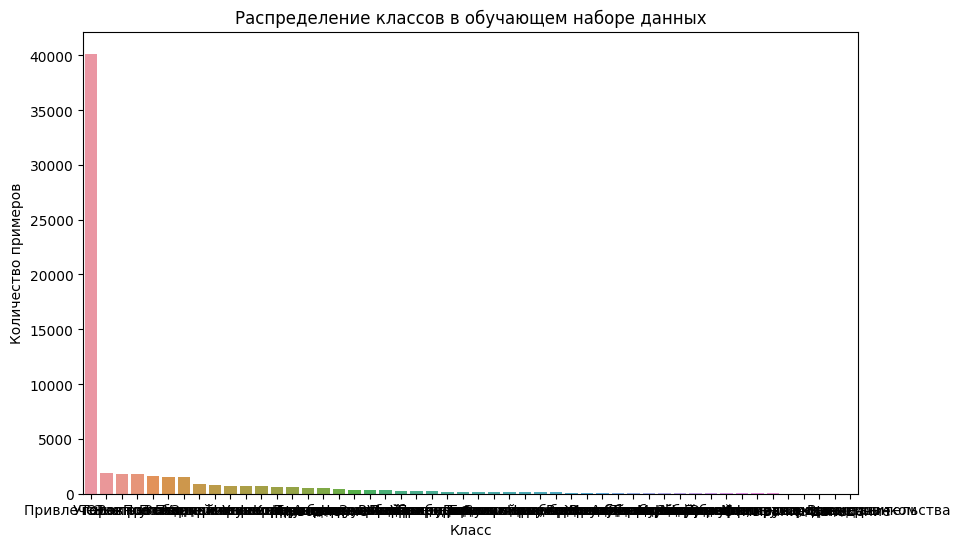

class
O                                                   40159
Теракт                                               1898
Взятки                                               1801
Экстремизм                                           1798
Уголовное обвинение                                  1634
Пожары                                               1510
Привлечение к уголовной ответственности              1475
Землетрясение                                         841
Утечка нефти                                          816
Противодействие коррупции                             707
Поддержка террористов                                 702
Заключение под стражу                                 694
Нарушение закона                                      636
Коррупция                                             599
Уголовное задержание                                  517
Наводнение                                            489
Кораблекрушение                                       378
Авиаката

In [6]:
# Анализ распределения классов в обучающем наборе данных
class_distribution = train_data['class'].value_counts()

# Визуализация распределения классов
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Распределение классов в обучающем наборе данных')
plt.xlabel('Класс')
plt.ylabel('Количество примеров')
plt.show()

class_distribution

Анализ распределения классов показывает, что данные сильно несбалансированы: класс "O" значительно преобладает над остальными. Такая несбалансированность классов может привести к тому, что модель будет склонна предсказывать более часто встречающийся класс, игнорируя менее распространённые. Чтобы справиться с этим, мы можем использовать техники взвешивания классов или пересемплирования данных.

In [7]:
# Проверим наличие пропущенных значений в колонке "Text" обучающего и тестового набора данных
missing_train = train_data["text"].isnull().sum()
missing_test = test_data["text"].isnull().sum()

missing_train, missing_test

(0, 0)

# Предобработка данных

In [8]:
# Загрузка стоп-слов
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))


# Инициализация стеммера
stemmer = RussianStemmer()

# Функция для предобработки текста
def preprocess_text(text):
    # Удаление специальных символов и приведение к нижнему регистру
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()

    # Токенизация
    tokens = word_tokenize(text)

    # Стемминг и удаление стоп-слов
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Предобработка текстов в обучающем и тестовом наборах данных
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Проверка результатов предобработки
train_data_processed_head = train_data[['text', 'processed_text']].head()
test_data_processed_head = test_data[['text', 'processed_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NeKonn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NeKonn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Функция для просмотра пропусков в данных
def check_missing_values(df):
    """
    Проверяет пропущенные значения в DataFrame и возвращает DataFrame с результатами.
    
    :param df: DataFrame для проверки
    :return: DataFrame с информацией о пропущенных значениях
    """
    # Вычисление количества пропущенных значений
    missing_values = df.isnull().sum()

    # Вычисление процента пропущенных значений
    missing_percentage = (missing_values / len(df)) * 100
    
    # Сборка нового DataFrame с информацией о пропущенных значениях
    missing_df = pd.DataFrame({
        'Columns': missing_values.index,
        'Missing Values Count': missing_values,
        'Missing Percentage (%)': missing_percentage
    }).reset_index(drop=True)
    
    # Возвращение результата
    return missing_df.sort_values(by='Missing Percentage (%)', ascending=False)
    
missing_data = check_missing_values(train_data)
missing_data

,Columns,Missing Values Count,Missing Percentage (%)
0,text,0,0.0
1,class,0,0.0
2,processed_text,0,0.0


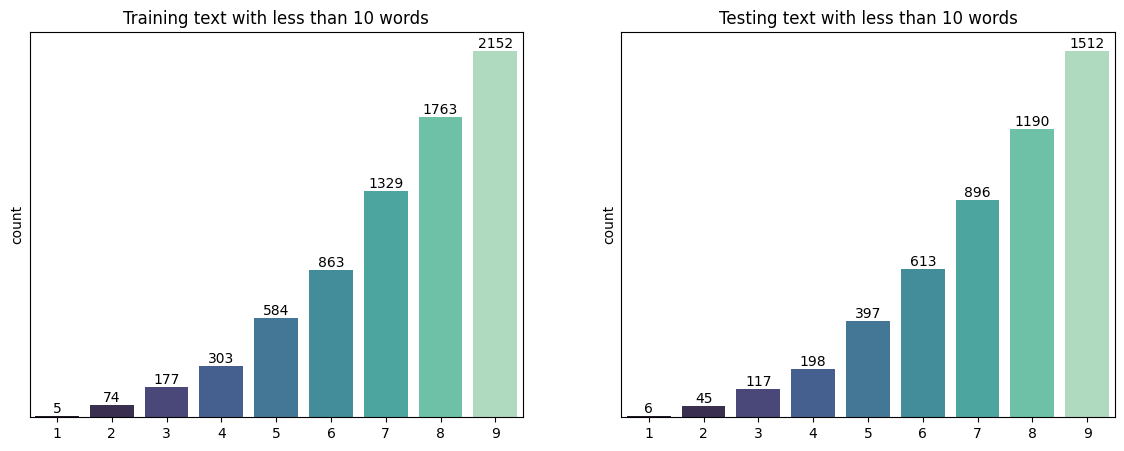

In [10]:
# Подсчет количества слов в каждом твите
train_data['text_len'] = train_data['text'].apply(lambda x: len(x.split()))
test_data['text_len'] = test_data['text'].apply(lambda x: len(x.split()))

# Построение графиков для твитов с менее чем 10 словами
def plot_text_length(train_data, test_data):
    plt.figure(figsize=(14,5))
    
    # Первый подграфик для обучающих данных
    plt.subplot(1, 2, 1)  # (rows, columns, panel number)
    ax1 = sns.countplot(x='text_len', data=train_data[train_data['text_len'] < 10], palette='mako')
    plt.title('Training text with less than 10 words')
    plt.yticks([])
    ax1.bar_label(ax1.containers[0])
    plt.ylabel('count')
    plt.xlabel('')
    
    # Второй подграфик для тестовых данных
    plt.subplot(1, 2, 2)
    ax2 = sns.countplot(x='text_len', data=test_data[test_data['text_len'] < 10], palette='mako')
    plt.title('Testing text with less than 10 words')
    plt.yticks([])
    ax2.bar_label(ax2.containers[0])
    plt.ylabel('count')
    plt.xlabel('')
    
    plt.show()

# Используем функцию для построения графиков для обучающих и тестовых данных
plot_text_length(train_data, test_data)

После проведения очистки некоторые строки оказались без слов. Поэтому мы их удаляем, и для целей моделирования мы оставляем только те строки, в которых больше 4 слов.

In [11]:
train_data = train_data[train_data['text_len'] > 4]
# test_data = test_data[test_data['text_len'] > 4]

In [23]:
# Инициализация токенизатора
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["processed_text"])

# Преобразование текста в последовательности чисел
train_sequences = tokenizer.texts_to_sequences(train_data["processed_text"])
test_sequences = tokenizer.texts_to_sequences(test_data["processed_text"])

# Определение максимальной длины последовательности
max_length = max([len(seq) for seq in train_sequences])

# Дополнение последовательностей до одной и той же длины
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

train_padded.shape, test_padded.shape

((1986450, 62), (40000, 62))

In [12]:
from sklearn.preprocessing import LabelEncoder

# Инициализация и обучение LabelEncoder на столбце 'class'
label_encoder = LabelEncoder()
train_data['encoded_class'] = label_encoder.fit_transform(train_data['class'])

# Получение словаря для перекодировки
class_to_encoded = dict(zip(train_data['class'], train_data['encoded_class']))
encoded_to_class = {v: k for k, v in class_to_encoded.items()}

# Вывод первых нескольких строк данных и словаря перекодировки
train_data.head(), class_to_encoded, encoded_to_class

(                                                text class  \
 0  При этом, продолжает Кудрин, лично он уверен: ...     O   
 1  Сотрудники 1-го отдела хранили информацию о ра...     O   
 2  Сирийские службы безопасности пока с этим спра...     O   
 3  В МВД сообщили, что ДНК мужчины совпала с обра...     O   
 4  Об этом сообщила в среду пресс-секретарь Белог...     O   
 
                                       processed_text  text_len  encoded_class  
 0  продолжа кудрин личн увер нацпроект например о...        26              0  
 1  сотрудник 1 го отдел хран информац работник от...        28              0  
 2  сирийск служб безопасн пок эт справля необходи...        16              0  
 3  мвд сообщ днк мужчин совпа образц найден тел ж...        13              0  
 4  сообщ сред пресс секретар бел дом джен псак ре...        15              0  ,
 {'O': 0,
  'Пожары': 31,
  'Заключение под стражу': 9,
  'Взятки': 5,
  'Уголовное обвинение': 43,
  'Теракт': 38,
  'Экстремизм': 4

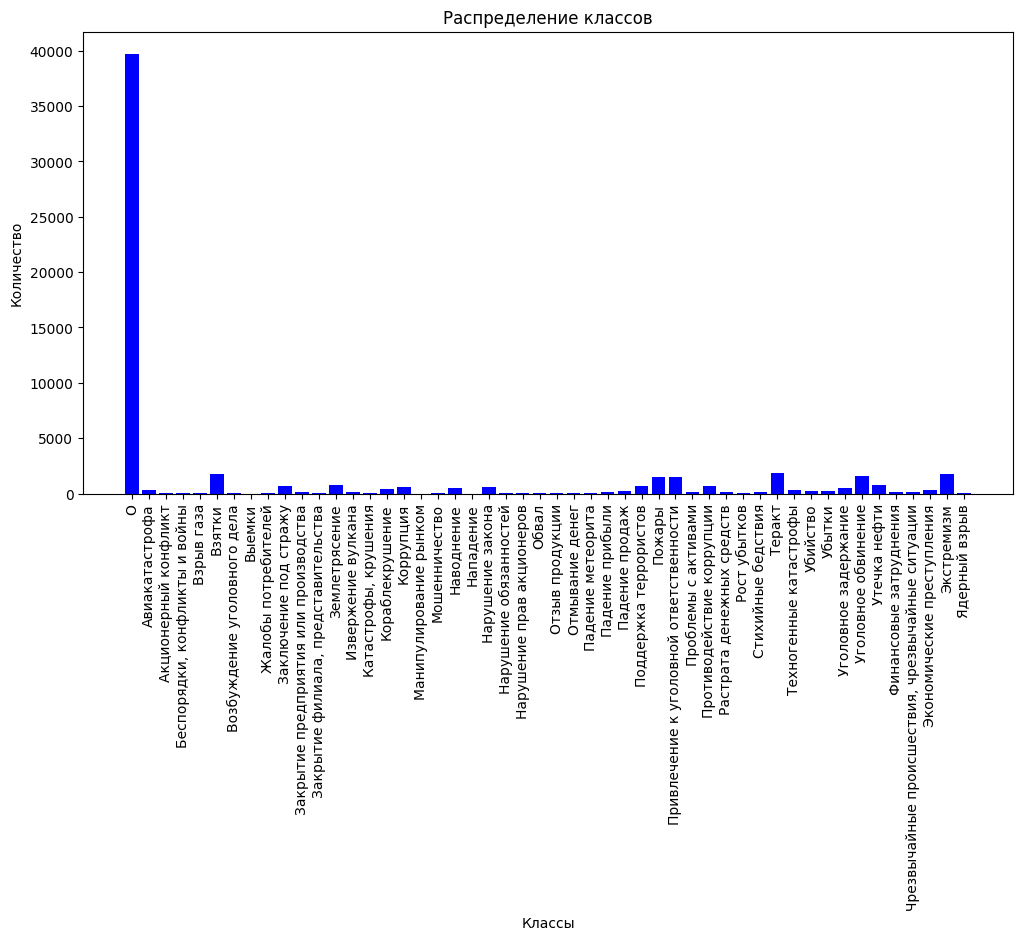

In [13]:
# Получение уникальных закодированных классов и их количества
unique_encoded, counts = np.unique(train_data['encoded_class'], return_counts=True)

# Преобразование числовых меток обратно в текстовые метки
unique_classes = [encoded_to_class[encoded] for encoded in unique_encoded]

# Визуализация распределения классов
plt.figure(figsize=(12, 6))
plt.bar(unique_classes, counts, color='blue')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение классов')
plt.xticks(rotation=90)  # Поворачиваем метки для лучшей читаемости
plt.show()

Мы видим, что у нас есть дисбаланс классов, поэтому используем Oversampling для борьбы с этим.

In [15]:
def oversample_data(df, target_col):
    # Определяем класс с максимальным количеством записей
    max_size = df[target_col].value_counts().max()

    # Создаем новый dataframe, который будет содержать наши перебалансированные данные
    balanced_df = pd.DataFrame()

    for class_name, group in df.groupby(target_col):
        # Для каждого класса дублируем записи, пока их количество не станет равным max_size
        balanced_group = group.sample(max_size, replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, balanced_group], axis=0)

    return balanced_df

train_data = oversample_data(train_data, 'class')
train_data['class'].value_counts()

class
O                                                   39729
Стихийные бедствия                                  39729
Падение метеорита                                   39729
Падение прибыли                                     39729
Падение продаж                                      39729
Поддержка террористов                               39729
Пожары                                              39729
Привлечение к уголовной ответственности             39729
Проблемы с активами                                 39729
Противодействие коррупции                           39729
Растрата денежных средств                           39729
Рост убытков                                        39729
Теракт                                              39729
Авиакатастрофа                                      39729
Техногенные катастрофы                              39729
Убийство                                            39729
Убытки                                              39729
Уголовно

In [24]:
# Пересоздаем train_sequences и train_padded после oversampling
train_sequences = tokenizer.texts_to_sequences(train_data["processed_text"])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

# Использование трансформеров

In [25]:
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [26]:
# Создание словаря для сопоставления меток с идентификаторами и наоборот
labels = train_data['class'].unique().tolist()
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Преобразование меток в идентификаторы
train_labels = train_data['class'].map(label_to_id).tolist()

# Разделение данных на обучающую и валидационную выборки
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.1, random_state=42
)

# Токенизация после разделения
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_data['text'].tolist(), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, max_length=256)

# Преобразование меток для val_data
val_labels = val_data['class'].map(label_to_id).tolist()

# Подготовка DataLoader
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

KeyboardInterrupt: 

In [ ]:
class EarlyStopping:
    """Ранняя остановка для прекращения обучения, если потери не улучшаются после определенного числа эпох."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): Как долго ждать после последнего времени улучшения. Default: 7.
            verbose (bool): Если True, выводит сообщение для каждого улучшения. Default: False.
            delta (float): Минимальное изменение для квалификации как улучшение. Default: 0.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Сохраняет модель, когда потери уменьшаются.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_to_id))
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Планировщик скорости обучения
scheduler = ExponentialLR(optimizer, gamma=0.1)

for epoch in range(3):
    model.train()
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Изменение скорости обучения
    scheduler.step()

    model.eval()
    val_loss = 0
    val_predictions = []
    true_labels = []
    for batch in val_loader:  # убедитесь, что у вас есть val_loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        val_predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)

    # Вывод потерь на валидации
    print(f"Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}")

    # Сохранение чекпоинта после каждой эпохи
    torch.save(model.state_dict(), f'checkpoint_epoch_{epoch+1}.pt')

In [ ]:
# Загрузка весов лучшей модели
model.load_state_dict(torch.load('checkpoint_epoch_2.pt'))  # или любой другой чекпоинт

# Вычисление точности на тренировочной выборке
model.eval()
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

train_accuracy = correct_predictions / total_predictions
print(f"Training Accuracy: {train_accuracy:.4f}")

# Вычисление точности на валидационной выборке
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

val_accuracy = correct_predictions / total_predictions
print(f"Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, max_length=256)

# Подготовка DataLoader для тестовых данных
test_dataset = TweetDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Загрузка весов лучшей модели
model.load_state_dict(torch.load('checkpoint_epoch_3.pt'))

# Получение предсказаний для тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        test_predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

In [ ]:
id_to_label = {encoded: label for encoded, label in encoded_to_class.items()}

In [ ]:
# Преобразование предсказанных идентификаторов обратно в метки
predicted_labels = [id_to_label[pred] for pred in test_predictions]

# Создание DataFrame для сохранения предсказаний
submission_data_3 = pd.DataFrame({
    'id': test_data['id'],  # использование столбца 'id' из тестовых данных
    'class': predicted_labels
})

# Сохранение предсказаний в CSV файл
submission_data_3.to_csv('predictions_3.csv', index=False)

In [ ]:
# Предобработка текстов
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Векторизация текста
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['processed_text'])
X_test = vectorizer.transform(test_data['processed_text'])

In [9]:
# Метки классов
y_train = train_data['class']

In [10]:
# Логистическая регрессия
lr_model = LogisticRegression()
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1_macro')
print(f"Логистическая регрессия F1-скор (макро): {np.mean(lr_scores)}")

C:\Users\NeKonn\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\NeKonn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\NeKonn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org

Логистическая регрессия F1-скор (макро): 0.38838123355815035


C:\Users\NeKonn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# Функция для одного шага кросс-валидации
def evaluate_one_split(split):
    train_index, test_index = split
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=50, n_jobs=-1)
    rf_model.fit(X_train[train_index], y_train[train_index])
    preds = rf_model.predict(X_train[test_index])
    return f1_score(y_train[test_index], preds, average='macro')

# Инициализация KFold
kf = KFold(n_splits=5)

# Использование tqdm для отображения прогресса
scores = [evaluate_one_split(split) for split in tqdm(kf.split(X_train), total=kf.get_n_splits())]
print(f"Случайный лес F1-скор (макро): {np.mean(scores)}")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.80s/it]

Случайный лес F1-скор (макро): 0.09139727162386388


In [18]:
# Создание экземпляра LabelEncoder и преобразование меток классов
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [22]:
# Параметры для использования GPU
params = {
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'verbosity': 2
}

# Создание модели XGBoost с параметрами для использования GPU
xgb_model = XGBClassifier(**params)

# Применение кросс-валидации
xgb_scores = cross_val_score(xgb_model, X_train, y_train_encoded, cv=5, scoring='f1_macro')
print(f"XGBoost F1-скор (макро): {np.mean(xgb_scores)}")

C:\Users\NeKonn\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboo

XGBoost F1-скор (макро): 0.015746552234011932


C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [34]:
# Функция для оценки модели
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Токенизатор
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Функция для токенизации набора текстов
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Применение функции токенизации к списку текстов
train_encodings = tokenize_function(train_data['text'].tolist())
test_encodings = tokenize_function(test_data['text'].tolist())

# Класс для создания датасета
class CustomDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Создание датасетов
train_dataset = CustomDataset(train_encodings, train_data['class'].tolist())
test_dataset = CustomDataset(test_encodings, test_data['class'].tolist())  

# Создание модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Пути для сохранения результатов и логов
# Директории для сохранения результатов и логов
output_dir = "results"
logging_dir = "logs"

# Создание директорий, если они не существуют
os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

# Создание директорий, если они не существуют
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(logging_dir):
    os.makedirs(logging_dir)

# Параметры обучения
training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir=logging_dir,
    logging_steps=10,  # Логирование каждые 10 шагов
    evaluation_strategy="steps",
    eval_steps=50,  # Выполнение оценки каждые 50 шагов
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Тренировка модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FailedPreconditionError: logs is not a directory

In [ ]:
# Логистическая регрессия
lr_model = LogisticRegression()
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1_macro')
print(f"Логистическая регрессия F1-скор (макро): {np.mean(lr_scores)}")
Логистическая регрессия F1-скор (макро): 0.38838123355815035

# Случайный лес
rf_model = RandomForestClassifier()
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1_macro')
print(f"Случайный лес F1-скор (макро): {np.mean(rf_scores)}")

# Параметры для использования GPU
params = {
    'tree_method': 'gpu_hist',  # Использование GPU оптимизированного алгоритма
    'predictor': 'gpu_predictor'  # Использование GPU для предсказаний
}

# Создание и обучение модели XGBoost
xgb_model = XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

# Оценка модели
xgb_predictions = xgb_model.predict(X_test)
xgb_f1_score = f1_score(y_test, xgb_predictions, average='macro')
print(f"XGBoost F1-оценка: {xgb_f1_score}")

# Функция для оценки модели
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Токенизация данных
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_data.map(tokenize_function, batched=True)
test_dataset = test_data.map(tokenize_function, batched=True)

# Создание модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)  # Перенос модели на GPU


# Параметры обучения
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Тренировка модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Что мне нужно тут изменить, чтобы улучшить качество моделей? 